Numerical Solutions for the GBLUP Problem
============================================

$\newcommand{\R}{\mathbb{R}}$ $\newcommand{\X}{\mathbf{X}}$ $\newcommand{\K}{\mathbf{K}}$ $\newcommand{\y}{\mathbf{y}}$

Let $X\in\mathbb{R}^{n\times p}$ be the genotype matrix and $y\in\mathbb{R}^{n}$ the vector with phenotypes. We are interested in estimating the marker effects $\hat\beta$ that can be obtained by solving the ridge regression problem
$$\hat\beta := \arg\min_{\beta \in \R^p} \|\X\beta - \y\|_2^2 + \lambda \|\beta\|_2^2$$

However, this is be inefficient since solving the normal equation requires operations with $p\times p$ large matrix $\X^T X$ and $p\gg n$. 

Fortunately, one can show that the same marker effects can be obtained by solving a on the Gram matrix $\K = \X\X^T$, which is only $n\times n$ large. Computation of the marker effects in this case involes solution of the system of equations
$$(\K+\lambda I)\alpha =  \y$$
followed by a simple matrix-vector multiplication
$$\hat\beta = X^T \alpha.$$

In this notebook we study the efficiency of different methods for solving the system of equations above. In particular, we consider

+ Conjugate gradients method (CG)
+ Minimum residuals method (MINRES)
+ Cholesky decomposition of $\K$
+ Eigenvalue decomposition of $\K$
+ Singular value decomposition of $\X$


Note: The regularization parameter $\lambda$ will stay the same and equal to 0.001 for all experiments, since we don't care about a particular hyperparameter.

We start by importing the modules and loading files.

In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.linalg
from scipy.sparse.linalg import cg, minres
import pandas as pd

from matplotlib import pylab
import seaborn as sbs
sbs.set_context("talk")

filename_data = "data/GenoFlintSYNrep2.csv"
filename_target = "data/PhenoFlintSYNrep2.csv"
lambda_ = 1e-3

data_df = pd.DataFrame.from_csv(filename_data)
data = data_df.as_matrix()
X = data

targets_df = pd.DataFrame.from_csv(filename_target)
targets = targets_df.as_matrix()
y = targets[:,2]

## Computation of the Gram Matrix $\K$

Most methods require the computation of the matrix $\K$. It is the most time-consuming operation in the whole process! 

CG and MINRES would not necessary require the explicit form of $\K$ as they rely only on dot-product implementations. However, since every CG-iteration have the same asymptotic complexity as computation $\K$, and $\K$ is small enough to fit into the memory, there is no way perform implicit computations.

*Valeriy: Alternatively, one could try to represent $\X$ in sparse matrix format and use implicit methods, but I don't see why it should work faster and hence this approach is not studied here.*

In [10]:
# compute K
%time K = X.dot(X.T)

CPU times: user 2min 58s, sys: 80 ms, total: 2min 58s
Wall time: 2min 58s


In [5]:
K_sparse = sp.sparse.csc_matrix(K)
X_sparse = sp.sparse.csr_matrix(X)

print "X: portion of nonzeros %f"%(float(X_sparse.nnz)/np.product(X_sparse.shape))
print "K: portion of nonzeros %f"%(float(K_sparse.nnz)/np.product(K_sparse.shape))

X: portion of nonzeros 0.151842
K: portion of nonzeros 1.000000


**First observation:** With 185 seconds, computation of the matrix $\K$ is the most expensive operation. My implementation of numeric libraries doesn't seem to support multithreaded `dot` and hence this time can potentially be **reduced by the factor of 4** leading to 46 seconds. This is hover still much longer than other operations would take.

**Second observation:** While the genotype matrix $\X$ is very sparse, having only 15% of the entries filled, the Gram matrix $\K$ is full. Nonetheless, in this particular case $\X$ has 2062777 non-zero elements, 10 times more than $\K$ with 203401 elements.

## Solution of Kernel Equations

We start by computing the left-handside matrix $A = \K + \lambda *I$ and solve the system of equations
$$ A x = \y.$$

In [15]:
A = K + lambda_ * np.eye(K.shape[0])

### Using CG

In [16]:
%timeit -n 10 -r 3 res_cg = cg(A, y, tol=1e-8)
res_cg = cg(A, y, tol=1e-8)

10 loops, best of 3: 11.6 ms per loop


### Using MINRES

In [23]:
# solve system using minres
%timeit -n 10 -r 5 res_minres = minres(A, y, tol=1e-8)
res_minres = minres(A, y, tol=1e-8)

10 loops, best of 5: 15.1 ms per loop


### Using Cholesky factorization of $A$

Since this solution method consists for two steps: Cholesky factorization of $A$ and backsubsitution, we measure this steps indivudally.

**Cholesky factorization:**

In [28]:
# perform Cholesky factorization
%timeit -n 10 -r 5 sp.linalg.cho_factor(A)
L, is_lower = sp.linalg.cho_factor(A)

10 loops, best of 5: 1.57 ms per loop


**Backsubstitution:**

In [29]:
# perform Cholesky backsubstitution
%timeit -n 10 -r 5 sp.linalg.cho_solve((L, is_lower), y)
x_cholesky = sp.linalg.cho_solve((L, is_lower), y)

10 loops, best of 5: 354 µs per loop


### Using Eigenvalue decomposition of $A$

Again, the solution method consists for two steps: eigenvalue decomposition of $A$ and backsubsitution.

**Eigenvalue decomposition:**

In [36]:
# eigenvalue decomposition of the matrix K
%timeit -n 10 -r 5 W,VR = sp.linalg.eig(A)
W,VR = sp.linalg.eig(A)

10 loops, best of 5: 92.7 ms per loop


**Backsubsitution:** (we program it explicitly since there is no buit-in method)

In [37]:
# eigenvalues backsubstitution
%timeit -n 10 -r 5  VR.dot(VR.T.dot(y)*(1./W.real))
x_ev = VR.dot(VR.T.dot(y)*(1./W.real))

10 loops, best of 5: 52.7 µs per loop


## Singular Value Decomposition of $\X$

We can avoid explicit computation of $\K$ by estimating the singular value sof $\X$. Let $\X = U S V$ with left and right singular vector matrices $U$ and $V$ and the singular values in $S$. Hence 
$$(\K+\lambda I)^{-1} = (\X\X^T + \lambda I)^{-1} = (USVV^{T}SU^{T} + \lambda I)^{-1}=(US^2U^T + \lambda I)^{-1} = U(S^2+\lambda I)^{-1} U^T$$

Hence we need to compute onlye the inverse of a diagonal matrix $(S^2+\lambda I)$, which is simple.

**Compute SVD:**

In [44]:
# singular values of X
%timeit -n 10 -r 3 sp.linalg.svd(X, full_matrices=False)
U, S, V = sp.linalg.svd(X, full_matrices=False)

10 loops, best of 3: 2.74 s per loop


**Backsubsitution:** (we program it explicitly since there is no buit-in method)

In [46]:
## backsustitution of SVD
%timeit -n 10 -r 3 U.dot(U.T.dot(y)*1./(S**2+lambda_))
x_svd = U.dot(U.T.dot(y)*1./(S**2+lambda_))

10 loops, best of 3: 124 µs per loop


# Sparse Matrices

Some of the methods can be used with matrices in sparse compressed format. Computation of the matrix $\K$ from compressed matrix $\X$ is much faster.

In [102]:
from scipy.sparse.linalg import eigs, eigsh, splu, svds, lobpcg

In [113]:
%timeit -n 10 -r 5 sp.sparse.csc_matrix(X)
X_sparse = sp.sparse.csc_matrix(X)


10 loops, best of 5: 433 ms per loop


In [114]:
%timeit -n 10 -r 5  X_sparse.dot(X_sparse.T)
K_sparse = X_sparse.dot(X_sparse.T)

10 loops, best of 5: 644 ms per loop


In [116]:
# obtaining dense K:
%timeit -n 10 -r 5 K_sparse.todense()

10 loops, best of 5: 1.82 ms per loop


In [106]:
A_sparse = K_sparse + lambda_ * np.eye(K_sparse.shape[0])

### Using CG

In [107]:
%timeit -n 10 -r 3 res_cg = cg(A_sparse, y, tol=1e-8)
res_cg_sparse = cg(A_sparse, y, tol=1e-8)

10 loops, best of 3: 11.3 ms per loop


### Using MINRES

In [115]:
# solve system using minres
%timeit -n 10 -r 5 res_minres = minres(A_sparse, y, tol=1e-8)
res_minres_sparse = minres(A_sparse, y, tol=1e-8)

10 loops, best of 5: 14.7 ms per loop


### Using LU factorization of $A$


**LU factorization:**

In [110]:
# perform LU factorization
%timeit -n 10 -r 5 splu(A_sparse)
invALU = splu(A_sparse)

10 loops, best of 5: 19.9 ms per loop


**Backsubstitution:**

In [111]:
# perform Cholesky backsubstitution
%timeit -n 10 -r 5 invALU.solve(y)
x_lu_sparse = invALU.solve(y)

10 loops, best of 5: 261 µs per loop


In [112]:
print("CG: difference norm {}".format(np.linalg.norm(res_cg[0]-res_cg_sparse[0])))
print("MINRES: difference norm {}".format(np.linalg.norm(res_minres[0]-res_minres_sparse[0])))
print("LU: difference norm {}".format(np.linalg.norm(x_cholesky-x_lu_sparse)))

CG: difference norm 0.0
MINRES: difference norm 0.0
LU: difference norm 6.39838234574e-16


# Timing Results Summary

I summarize the measurements in the table below. The measurements may vary from one run of the notebook to another hence they not necessarily coincide with currently presented time measurements above.

| Method               | Create $\K$ | Decompositon | Solution  | Total         |
|----------------------|-------------|--------------|-----------|---------------|
| CG                   | 199 s       |              | 11.9 ms   | 199.0119 s    |
| MINRES               | 199 s       |              | 14.7 ms   | 199.0147 s    |
| Eigenval. decom. $A$ | 199 s       | 93ms         | 0.0884 ms | 199.0930884 s |
| Cholesky             | 199 s       | 1.83 ms      | 0.572 ms  | 199.002402 s  |
| CG Sparse            | 1.077 s     |              | 11.3 ms   | 1.0883 s      |
| MINRES Sparse        | 1.077 s     |              | 14.7 ms   | 1.0918 s      |
| LU Sparse            | 1.077 s     | 19.9ms       | 0.261 ms  | 1.09716 s     |
| SVD of $\X$          |             | 2.74 s       | 0.124 ms  | 2.740124 s    |


All timing results are performed on a skylake i5 processors with 2 real cores (4 hyperthreaded cores) with multithreading turned in.

* *It is smart to compress $\X$ into CSC format before computing $\K$. If needed $\K$ can be represented as a dense matrix again. This reduces the computational time from ca. 200 seconds to 1 second.*
* If the time for computation of $\K$ is ignored, CG offers the fastes solution for a single values of $\lambda$, followed closely by MINRES. 
* If solution for many different values of $\lambda$ is important, than investing into computing Eigevalued decomposition of $\K$ pays out after ca. 8 different $\lambda$ values.
* Cholesky offers a significantly faster decomposition step, however, cannot be used with different $\lambda$ values.
* If the computation of $\K$ is taken into account, this time dominates everything else. In this case ca 3 seconds for SVD of $\X$ seems like a better alternative than 199 seconds for computation of $\K$.

# Verification

We plot the computed values of $\lambda$ against each other  to verify that they all lie on the same lines.m

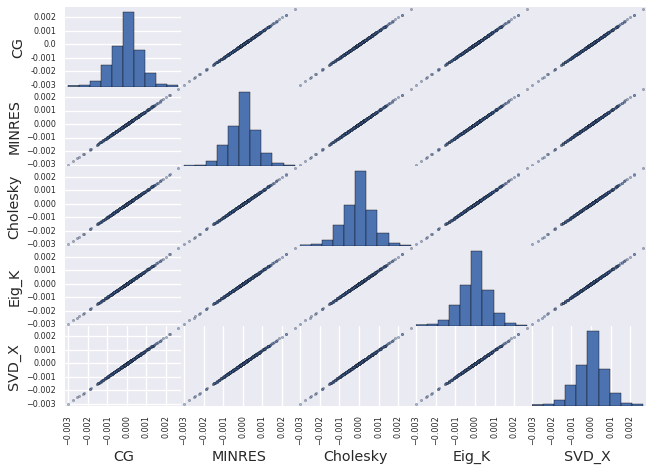

In [64]:
import pandas as pd

alphas = pd.DataFrame(np.vstack([res_cg[0], res_minres[0], x_cholesky, x_ev, x_svd]).T, 
                           columns=['CG', 'MINRES', 'Cholesky', 'Eig_K', 'SVD_X'])

plot = pd.scatter_matrix(alphas)

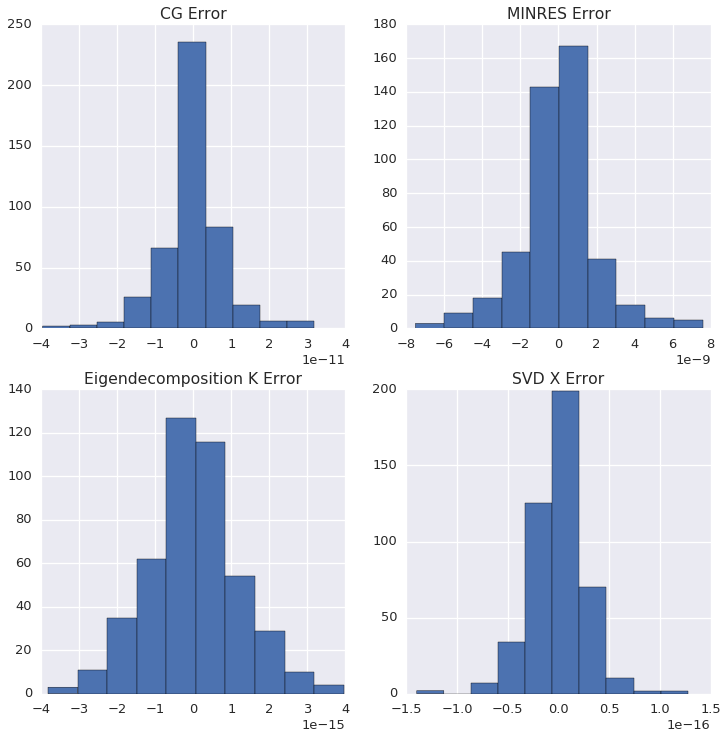

In [92]:
alphas = pd.DataFrame(np.vstack([res_cg[0], res_minres[0], x_cholesky, x_ev, x_svd]).T, 
                           columns=['CG', 'MINRES', 'Cholesky', 'Eig_K', 'SVD_X'])

pylab.figure(figsize=(12,12))
pylab.subplot(2,2,1)
pylab.hist(alphas.Cholesky-alphas.CG)
pylab.title("CG Error")
pylab.subplot(2,2,2)
pylab.hist(alphas.Cholesky-alphas.MINRES)
pylab.title("MINRES Error")
pylab.subplot(2,2,3)
pylab.hist(alphas.Cholesky-alphas.Eig_K)
pylab.title("Eigendecomposition K Error")
pylab.subplot(2,2,4)
pylab.hist(alphas.Cholesky-alphas.SVD_X)
pylab.title("SVD X Error")

Here we plot the histogram of the difference between the (exact) Cholesky solution and other solutions. We observe that iterative methods CG and MINRES produce a little bit higher error due to the tolerance threshold of  $10^{-8}$ we used. Eigenvalue decomposition and SVD differ from Cholesky in the range of $10^{-15}$ due to machine precision.

Hence, **all methods produce essentially the same results**.

<a id='numerics'></a>
## Numerics of Eigenvalues and Singular Values

We compare the eigenvalues computed for $\K$ with squared singular values computed for $\X$. 

Bothe plots perfectly overlap which means that we can perfectly reconstruc then eigenvalues from singular values using our numerical methods.

Note that the `eig` method from scipy did not completely sorted the eigenvlaues initially which result int the irregular blue line.

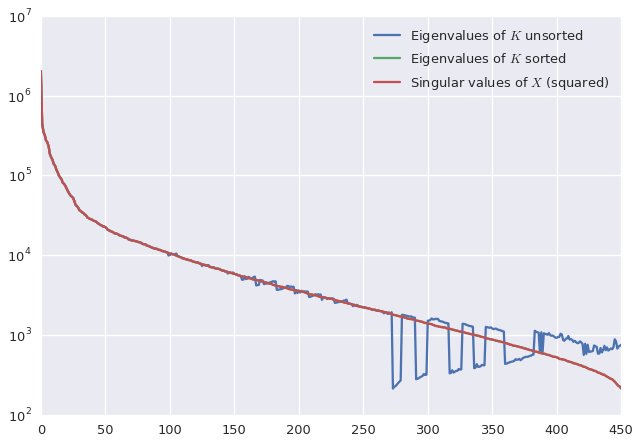

In [96]:
pylab.plot(W.real, '-', label=r"Eigenvalues of $K$ unsorted")
pylab.plot(sorted(W.real, reverse=True), '-', label=r"Eigenvalues of $K$ sorted")
pylab.plot(S**2, '-', label=r"Singular values of $X$ (squared)") 
pylab.yscale("log")

pylab.legend(loc='best')

# Addendum 

## Estimation of the Variance

Let $K = Q \Lambda Q^{-1}$. Hence to compute the estimator we can use
$$K(K+\lambda I)^{-1} = Q \Lambda Q^{-1}(Q\Lambda Q^{-1} + \lambda I)^{-1} = Q \Lambda Q^{-1}(Q(\Lambda + \lambda I)Q^{-1})^{-1} = Q\frac{\Lambda}{\Lambda+\lambda I}Q^{-1}$$

To compute the variance of the estimator we have
\begin{align}
V(\lambda) &= \frac{1}{n}\frac{\|(I-A(\lambda))y\|_2^2}{\left(\tfrac{1}{n}\text{trace}\left(I-A(\lambda)\right)\right)^2} = \frac{\left\|Q\frac{\Lambda + \lambda I - \Lambda}{\Lambda + \lambda I}Q^{-1}y\right\|_2^2}{\left(\tfrac{1}{n} \sum_{j=1}^n \frac{\lambda}{\lambda_j + \lambda}\right)^2}\\
&= n \cdot \frac{y^T Q\left(\frac{\lambda I}{\Lambda + \lambda I}\right)^2 Q^{-1} y}{\sum_{j=1}^n \frac{\lambda}{\lambda_j + \lambda}}
\end{align}
where $\lambda_j$ denotes the $j$-th eigenvalue and $\lambda$ denotes the regularization parameter. 